# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms,models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-19 17:49:26 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar" [1]
2023-12-19 17:49:28 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar" [1]
2023-12-19 17:49:30 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy" [1]


In [4]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [5]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)


Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


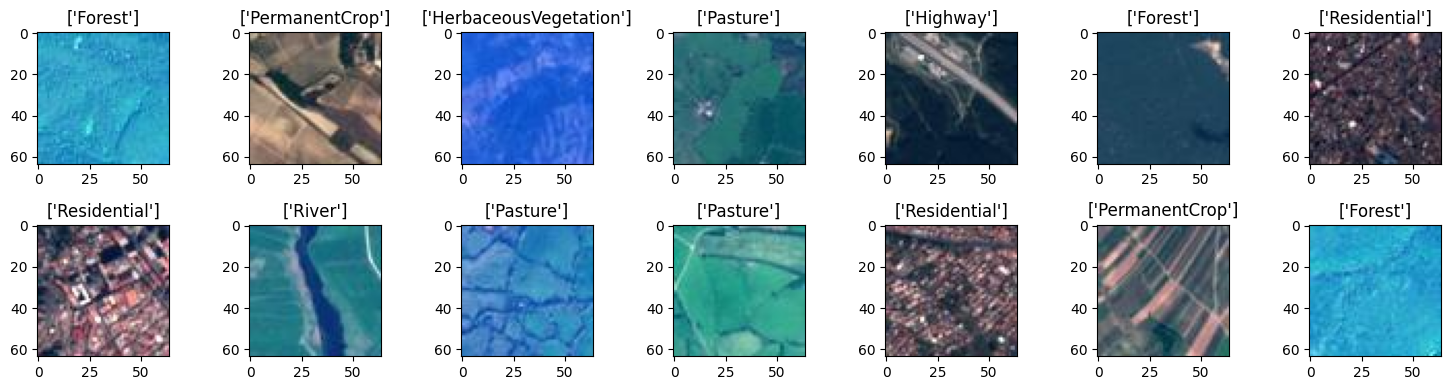

In [6]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

In [7]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
print(y_train)


[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


# Model

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [8]:
# Prepare data for training
import imgaug.augmenters as iaa
import imgaug as ia


X_train, X_test = X_train/255, X_test/255
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
print(mean)
print(std)


[0.29088279 0.41201959 0.48920503]
[0.2240432  0.17601508 0.21699366]


In [10]:
# Assuming X_train and y_train are PyTorch tensors
#=A.ShiftScaleRotate(p=0.5)
#i=0
#for im in X_train :
 #  np.random.seed(7)
 #  augmented_im=transform(image=im)
  # np.concatenate((X_train,augmented_im))
  # i=i+1

#np.tile(y_train,2)
import imgaug.augmenters as iaa
import imgaug as ia

# Créez un séquenceur d'augmentation avec les transformations souhaitées
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Retournement horizontal avec une probabilité de 50%
    iaa.Affine(rotate=(-10, 10)),  # Rotation dans la plage de -10 à 10 degrés
    iaa.GaussianBlur(sigma=(0, 1.0))  # Flou gaussien avec un écart-type de 0 à 1.0
])

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.data = x_train
        self.labels = y_train
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]  # Assurez-vous que img est une image PIL ou un ndarray

        # Convertir l'image en ndarray si ce n'est pas déjà fait
        if not isinstance(img, np.ndarray):
            img = np.array(img)

        sample = {'image': img, 'label': self.labels[index]}

        if self.transform:
            sample = self.transform(sample)

        return sample


# Créer une instance de MyDataset avec les données d'entraînement et les transformations


# Exemple d'utilisation
# Supposons que x_train et y_train sont vos données d'entraînement



# Créer une instance de MyDataset avec les données d'entraînement et les transformations


# X_train_augmented contient les données augmentées et y_train_augmented les étiquettes.

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#my_dataset = MyDataset(X_train, y_train, transform=seq)
#print(len(my_dataset))






# Convert data to PyTorch tensors and normalize images


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
#my_dataset = MyDataset(X_train, y_train, transform=transform)

X_train_tensor = torch.stack([transform(img) for img in X_train]).float()
X_valid_tensor = torch.stack([transform(img) for img in X_valid]).float()
X_test_tensor = torch.stack([transform(img) for img in X_test]).float()
y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_valid)

In [11]:
# Define the simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3=nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.conv4=nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2=  nn.Linear(512, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x=F.relu(self.conv3(x))
        x=self.pool(x)
        x=F.relu(self.conv4(x))
        x=self.pool(x)
        x = x.view(-1, 256*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)






In [14]:

# Instantiate the model
model = models.resnet50(pretrained=True)
#model=models.vgg16(pretrained=False)
#num_filters=model.classifier[6].in_features
#model.classifier[6]=nn.Linear(num_filters,10)
num_filters=model.fc.in_features
model.fc=nn.Linear(num_filters,10)
# Print the model architecture
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())  # You can set learning rate, weight decay, etc.

# Training loop
num_epochs = 5
batch_size = 32

#train_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
for epoch in range(num_epochs):
    model=model.to(device)
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {valid_loss / len(valid_loader):.3f}, Accuracy: {100*accuracy:.2f}%')

Epoch 1/5, Validation Loss: 0.562, Accuracy: 81.72%
Epoch 2/5, Validation Loss: 0.435, Accuracy: 87.16%
Epoch 3/5, Validation Loss: 0.247, Accuracy: 91.44%
Epoch 4/5, Validation Loss: 0.275, Accuracy: 90.44%
Epoch 5/5, Validation Loss: 0.340, Accuracy: 89.94%


# Create Your Submission

In [ ]:
def create_submission(str,predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open(f"{str}.npy", 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [ ]:



# Use the following code in the submission cell of your project notebook
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "Lahmouz"
from datetime import datetime
# Get the current date
current_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = current_date.strftime("%m_%d_%y")

create_submission(f"{NAME}_{formatted_date}",predictions)




[[ -1.32769072  -1.986673    -0.72338283  -4.24805307  -5.53215361
    8.66281891  -2.69258451  -7.89448881  -4.29439259  -5.33717537]
 [ -3.99871087  -5.45666361  -0.11557716  -1.58786976   5.10484219
   -0.16313455  -0.51224267  -1.11486661  -4.01037407  -6.96259451]
 [ -2.18334699 -14.85001755  -2.99963164   0.8187151    0.49999976
    0.42253765   9.62876701  -5.36187792  -6.45866489 -17.02322388]
 [ -1.9016428    7.51610279  -0.23268676  -6.91650677  -9.2193079
    1.31074739  -4.61657953  -5.13578606  -3.73225856  -1.31330669]
 [ -2.67136908  -2.05997252   0.42825803  -2.54658484  -5.28586817
   -5.69344139  -3.89421511  -6.57971716   7.90803719  -6.44235134]]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !


In [ ]:
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "NAME"
from datetime import datetime
# Get the current date
current_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = current_date.strftime("%m_%d_%y")
create_submission(f"{NAME}_{formatted_date}",predictions)

[[-6.81732321e+00 -8.02040958e+00 -9.62419891e+00 -7.61651278e+00
  -2.07759991e+01 -1.12532210e-02 -1.07668133e+01 -1.96667461e+01
  -4.69228935e+00 -1.07394199e+01]
 [-9.86174202e+00 -1.89906788e+01 -3.28822637e+00 -2.56381536e+00
  -1.50196165e-01 -1.15593386e+01 -3.77123547e+00 -6.21561146e+00
  -9.96095276e+00 -1.62473354e+01]
 [-6.39771223e+00 -1.35150404e+01 -2.82438540e+00 -5.26736403e+00
  -8.67368507e+00 -6.85372257e+00 -6.98726475e-02 -9.73608017e+00
  -1.03594494e+01 -1.38142891e+01]
 [-5.58645535e+00 -5.10905944e-02 -1.05355902e+01 -1.08468838e+01
  -2.02145748e+01 -3.17035747e+00 -1.02541218e+01 -1.47862415e+01
  -5.63076115e+00 -7.81639528e+00]
 [-1.04978666e+01 -9.47060299e+00 -5.94816875e+00 -5.54229736e+00
  -1.23377981e+01 -1.04872198e+01 -8.42364979e+00 -9.08873272e+00
  -7.03950692e-03 -1.09676027e+01]]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !
